# Wicklow isolates snpgenie analysis

* https://www.microbiologyresearch.org/content/journal/mgen/10.1099/mgen.0.000388?crawler=true

In [1]:
import sys,os,shutil,subprocess
import glob
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width', 200)
import pylab as plt
import matplotlib as mpl
from Bio import SeqIO
sys.path.append('pathogenie')
from snipgenie import tools, aligners, app, trees, plotting

## Run workflow 

Add outgroup samples from Northern Ireland..

In [3]:
reload(app)
reload(tools)
args = {'threads':12, 'outdir': '/storage/btbgenie/wicklow_results', 'labelsep':'_',
        'input':['/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/',
                 '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/',
                 '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_09-07-18/',
                 '/storage/btbgenie/mbovis_ireland/Wicklow/dog',
                 '/storage/btbgenie/mbovis_ireland/temp_outgroup/'
                 ],
         'omit_samples':['161-MBovis'],
         'reference': None, 'overwrite':False,
         'trim': False,
         'filters' : 'QUAL>=30 & FMT/DP>=30 && DP4>=4 && MQ>35',
         'custom_filters': True,
         'mask': app.mbovis_mask,        
         'buildtree':True}
W = app.WorkFlow(**args)
st = W.setup()
W.run()

The following options will be used
-------
threads : 12
outdir : /storage/btbgenie/wicklow_results
labelsep : _
input : ['/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_07-01-18/', '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_15-03-19/', '/storage/btbgenie/mbovis_ireland/Wicklow/Fastqs_09-07-18/', '/storage/btbgenie/mbovis_ireland/Wicklow/dog', '/storage/btbgenie/mbovis_ireland/temp_outgroup/']
omit_samples : ['161-MBovis']
reference : None
overwrite : False
trim : False
filters : QUAL>=30 & FMT/DP>=30 && DP4>=4 && MQ>35
custom_filters : True
mask : /home/farrell/gitprojects/snipgenie/snipgenie/data/Mbovis_AF212297_mask.bed
buildtree : True
quality : 25
aligner : bwa
gb_file : None
bootstraps : 100

50 samples were loaded:
----------------------
                           name     sample                                           filename  pair  read_length
0   17-MBovis_S21_L001-4_R1_001  17-MBovis  /storage/btbgenie/mbovis_ireland/Wicklow/Fastq...     1          149
1   26-MBovis

In [ ]:
#snprecs, smat = tools.fasta_alignment_from_vcf('/storage/btbgenie/wicklow_results/filtered.vcf.gz', omit=['161-MBovis'])

In [2]:
meta = pd.read_csv('/storage/btbgenie/mbovis_ireland/all_ireland_samples.csv')
meta=meta[~meta.species.isnull()]
spo = pd.read_csv('/storage/btbgenie/spoligotypes.csv')
spo=spo.fillna('')

In [3]:
def color_clades(t, clades): 

    colors=['LightGray','Beige']
    for common,clr in zip([wick],colors):
        nodesinbranch = [node for node in common.traverse()]
        nstyle1=NodeStyle()
        nstyle1['bgcolor']=clr
        common.set_style(nstyle1)

In [4]:
def get_nodes(t):
    nodes=[]
    for node in t.traverse():
        nodes.append(node.name)
    return nodes

def set_nodestyle(t):
    nstyle = NodeStyle()
    #nstyle["shape"] = "sphere"
    nstyle["size"] = 3
    #nstyle["fgcolor"] = "gray"

    #nstyle["hz_line_type"] = 1
    #nstyle["hz_line_color"] = "#cccccc"

    # Applies the same static style to all nodes in the tree. Note that,
    # if "nstyle" is modified, changes will affect to all nodes
    for n in t.traverse():
       n.set_style(nstyle)

In [5]:
def remove_random_nodes(t,n):
    import random
    nodes=get_nodes(t) 
    #print (nodes)
    rm = random.sample(nodes, n)
    print (rm)
    for node in rm:
        trees.delete_nodes(t, node)
    #print (get_nodes(t) )

In [16]:
labelmap = dict(zip(meta['sample'],meta.species))
labelmap = dict(zip(spo['sample'],spo.SB))
colors = {'Cow': 'blue', 'Deer': 'green','Badger':'red', 'Dog':'orange'}
meta['color'] = meta.species.apply(lambda x: colors[x],1)
colormap = dict(zip(meta['sample'],meta.color))
t,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants', None)
#remove_random_nodes(t, 50)
rm = ['38', '15-11643', '9', '0', '94', '45', '95', '45-MBovis', '32', 'ref', '96', '99', '100',
      '26-12883', '82', '19-11957', '56-MBovis', '22-12200', '19-2438', '50-MBovis', 
      '44-MBovis', '54-MBovis', '13-11594', '7-10423', '100', '6', '37', '81', '49-MBovis',
      '51-MBovis', '25-MBovis', '95', '43-MBovis', '42-MBovis', '17-11662', '28', '37-MBovis', 
      '6', '98', '98', '52-3698', '59-6110', '19-MBovis', '99', '35-MBovis', '36-MBovis', '10', '6', '48-2919', '97']
for node in rm:
    trees.delete_nodes(t, node)

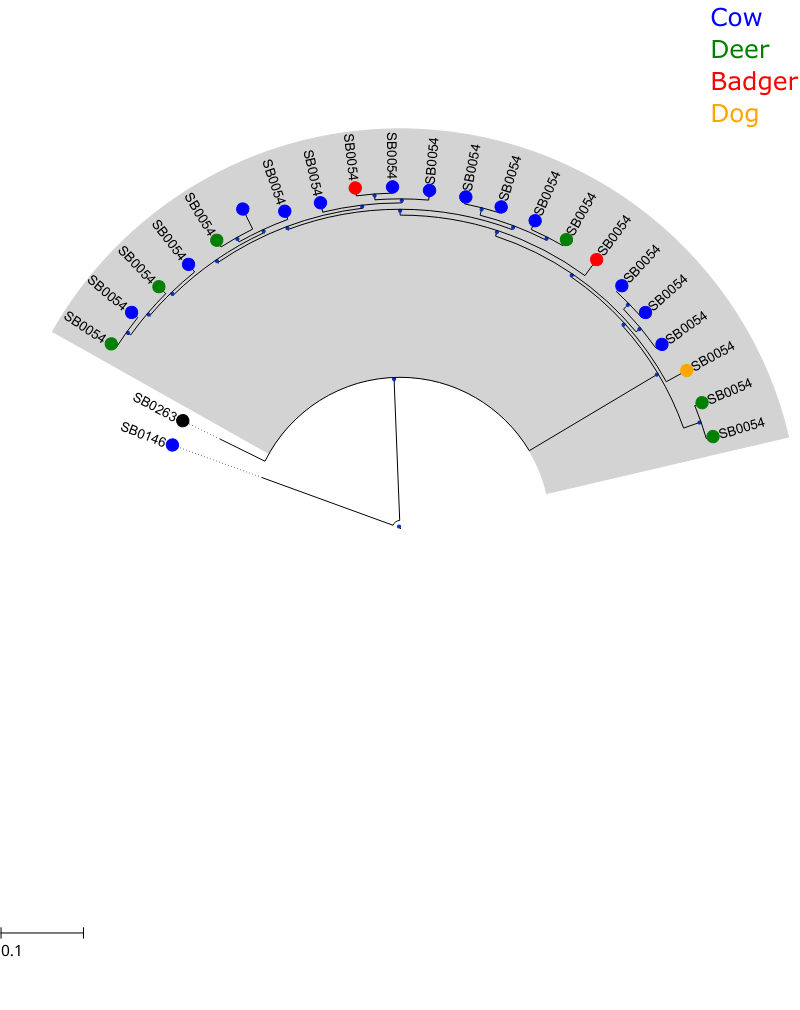

In [17]:
from ete3 import CircleFace, TreeStyle, NodeStyle, RectFace, TextFace
R = t.get_midpoint_outgroup()
t.set_outgroup(R)
#N = t.search_nodes(name="ref")[0]
#N.delete()
#trees.delete_nodes(t, ['182-MBovis'])
set_nodestyle(t)
nn=get_nodes(t)
wick = t.get_common_ancestor('1034', nn[10])
color_clades(t,wick)
trees.color_leaves(t, colormap)
trees.set_tiplabels(t,labelmap)

for i in colors:
    f=ts.legend.add_face(
            TextFace(text=i,fgcolor=colors[i],fsize=18),            
            column=0)

ts.mode='c'
ts.arc_start = 200 
ts.arc_span = 150

ts.scale=800
ts.branch_vertical_margin = 10
ts.scale_length = .1

t.render("%%inline",tree_style=ts,w=800)
#ti=t.render("/storage/btbgenie/wicklow_dog_tree.png",tree_style=ts,w=1400)

## snp distance matrix

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:629: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


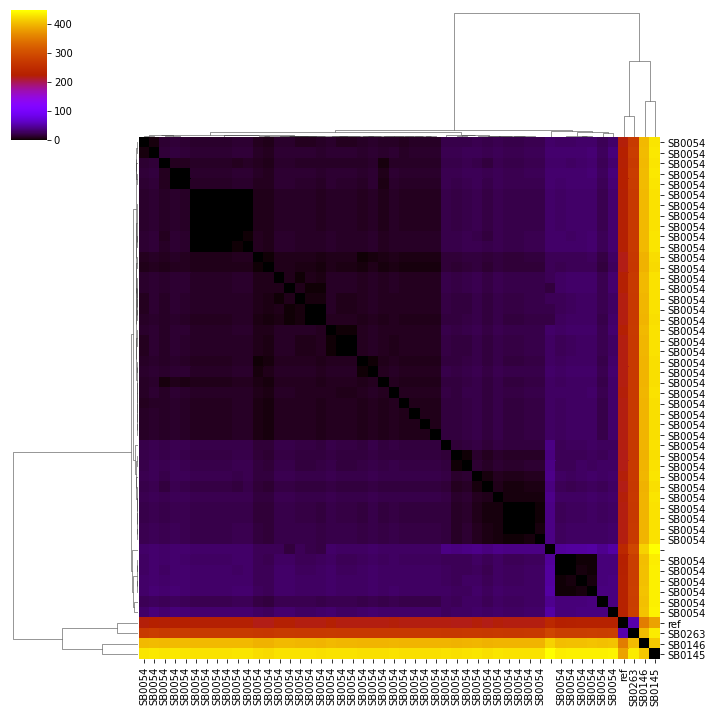

In [10]:
sm = pd.read_csv('/storage/btbgenie/wicklow_results/snpdist.csv',index_col=0)
sm=sm.rename(columns=labelmap,index=labelmap)
sm[-10:]
import seaborn as sns
sns.clustermap(sm, cmap='gnuplot',xticklabels=True,yticklabels=True)

## RD analysis

In [ ]:
from snpgenie import rdiff
reload(rdiff)
rdiff.create_rd_index()
df = W.fastq_table
res = rdiff.find_regions(df,'/storage/btbgenie/wicklow_rd',threads=12)

In [ ]:
X = rdiff.get_matrix(res, cutoff=0.15)
X['ident'] = X.apply(rdiff.apply_rules,1)
plotting.heatmap(X.set_index('ident',append=True), cmap='cubehelix',h=8)
#plt.savefig('rd_wicklow.png')

# vs JC pipeline results
## Compare sites matrix

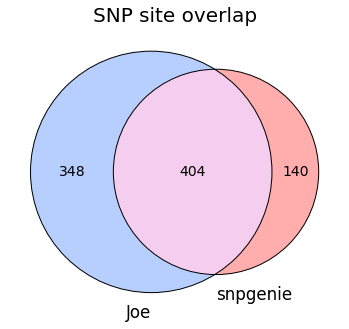

In [54]:
smat = pd.read_csv('/storage/btbgenie/wicklow_results/core.txt',sep=' ',index_col=0)
smat.index
joe_sites = pd.read_csv('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/FASTA/fastaPositions_Prox-10_18-12-2019.txt')
#print (joe_sites)
plt.figure(figsize=(6,6))
import matplotlib_venn
#mpl.rc('text', usetex=True)
mpl.rc('font',size=14)
sets=[set(joe_sites.Position),set(smat.index)]
matplotlib_venn.venn2(sets,set_labels=['Joe','snpgenie'],set_colors=['#4d88ff','#ff3333'])
ax=matplotlib_venn.venn2_circles(sets,linewidth=1)
plt.title('SNP site overlap',fontsize=20)
plt.savefig('snp_overlap_joe.png',dpi=100)

## identify non overlapping sites

In [55]:
df = app.read_csq_file('/storage/btbgenie/wicklow_results/csq.tsv')
x = df.set_index(['start','gene','aa','sample'])['nuc'].unstack('sample')

len(x), len(smat)

(524, 544)

In [ ]:
n=list(set(joe_sites.Position) - set(smat.index))
csqmat = pd.read_csv('../test_results/csq.matrix')#.set_index(['gene','aa'])
x[x.start.isin(n)]

In [59]:
#frequencies of sites
sitefreqs = (csqmat.sum(1)/len(csqmat.columns)).sort_values(ascending=False)
sitefreqs.value_counts()

0.0625    1798
0.1875     881
0.1250     403
0.7500     153
0.6875      77
0.8750      64
0.2500      36
0.4375      21
0.5000      10
0.6250       6
0.3750       3
0.5625       3
0.3125       2
dtype: int64

In [6]:
#print(W.fastq_table)
meta['name'] = meta.Forward.apply(lambda x: x.split('.')[0])
print(meta.loc[0])
s = pd.merge(W.fastq_table,meta,on='name')
labelmap = dict(zip(s['sample'],s.County))
#print (labelmap)


SeqID                                        1034
Forward           1034_S91_L001-4_R1_001.fastq.gz
Reverse           1034_S91_L001-4_R2_001.fastq.gz
NumberMapped                               902962
MappingProp                              0.999386
SequencingDate                           24-09-19
County                                   Monaghan
VCF                                 1034_1.vcf.gz
Coverage                                 0.900721
AverageDepth                              27.7094
Aliquot                               TB19-001034
Species                                       NaN
Date                                          NaN
name                       1034_S91_L001-4_R1_001
Name: 0, dtype: object


In [ ]:
reload(trees)
mytree,ts = trees.create_tree('/storage/btbgenie/wicklow_results/RAxML_bipartitions.variants')# ref='ref',labelmap=labelmap)
mytree.render("%%inline",tree_style=ts)

## Compare trees

In [ ]:
reload(trees)
t = trees.create_tree('/storage/btbgenie/JoeROIData/Mbovis/Wicklow/mlTree_WICKLOW_18-12-2019.tree')#, labelmap)
t.render("%%inline")

## bionumerics comparison

In [76]:
reload(app)
reload(tools)
#run only samples to compare to bionumerics tree
names = ['26-12883','55-4348','48-2919','59-6110','41-2165','52-3698','51-3292','13-11594',
         '17-11662','19-11957','28-12935','15-11643','31-12952','22-12200']

path='/storage/btbgenie/wicklow_results/mapped/'
bam_files = app.get_files_from_paths(path, '*.bam', filter_list=names)
#print (bam_files)
app.run_bamfiles(bam_files, app.mbovis_genome,outdir='wicklow_compare',threads=10,custom_filters=True,mask=None)

wicklow_compare/raw.bcf already exists
calling snps..
bcftools call -V indels --ploidy 1 -m -v -o wicklow_compare/calls.vcf wicklow_compare/raw.bcf
bcftools reheader --samples wicklow_compare/samples.txt -o /tmp/calls.vcf wicklow_compare/calls.vcf
bcftools filter -i "QUAL>=40 && FORMAT/DP>=30 && DP4>=4 && MQ>30" -o wicklow_compare/filtered.vcf.gz -O z wicklow_compare/calls.vcf
proximity filter found 382/405 sites
took 13.0 seconds
found 83 sites
0 sites with at least one missing sample
299 uninformative sites
raxmlHPC-PTHREADS -f a -N 100 -T 8 -m GTRCAT -V -p 28397685 -x 78313451 -n variants -w /home/damien/gitprojects/snipgenie/notebooks/wicklow_compare -s wicklow_compare/core.fa


In [71]:
vdf=tools.vcf_to_dataframe('wicklow_compare/filtered.vcf.gz')
len(vdf.mut.unique())

490

In [9]:
import toytree 
import toyplot 
tre1 = toytree.tree('wicklow_compare/RAxML_bipartitions.variants')
#tre1 = toytree.tree('wicklow_compare/fasttree.newick')
tre1=tre1.drop_tips(wildcard="ref")
tre2 = toytree.tree('bionumerics_wicklow.newick')

In [10]:
#tre1.rotate_node(names=["28-12935",'15-11643']).draw()
tre1 = tre1.root(wildcard="15-11643")
tre1.draw( node_sizes=3,# tip_labels_colors=toytree.colors,
    width=500,
    height=400,
    tip_labels_style={   
        "font-size": "16px",
        "-toyplot-anchor-shift": "10px"},scalebar=True )


(<toyplot.canvas.Canvas at 0x7f250082b910>,
 <toytree.Render.ToytreeMark at 0x7f2500839cd0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="td899c66aae45405daee925c713cd176b"> 48-2919 59-6110 55-4348 26-12883 52-3698 41-2165 51-3292 17-11662 13-11594 22-12200 31-12952 19-11957 28-12935 15-11643 0.0 0.1 0.3 0.4 0.5

In [11]:
tre2 = tre2.root(wildcard="15-11643")
tre2.draw( node_sizes=3,
    width=500,
    height=400,
    tip_labels_style={   
        "font-size": "16px",
        "-toyplot-anchor-shift": "10px"},scalebar=True )

(<toyplot.canvas.Canvas at 0x7f25007d80d0>,
 <toytree.Render.ToytreeMark at 0x7f25007de7f0>)

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="400.0px" viewBox="0 0 500.0 400.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="te9c97b03f39244488922212571bfa27a"> 59-6110 48-2919 55-4348 26-12883 52-3698 41-2165 51-3292 17-11662 13-11594 22-12200 19-11957 31-12952 28-12935 15-11643 0 9 18 28 37